Dataset:
             Sales
Month            
2009-01-01  168.0
2009-02-01  177.0
2009-03-01  198.0
2009-04-01  193.5
2009-05-01  181.5


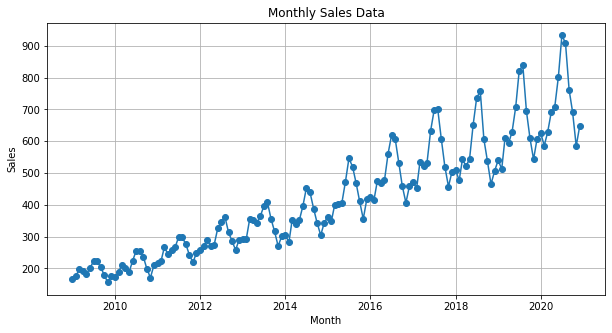

Epoch 1/500
12/12 [==============================] - 6s 101ms/step - loss: 0.0503 - val_loss: 0.0182
Epoch 2/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0149 - val_loss: 0.0288
Epoch 3/500
12/12 [==============================] - 0s 18ms/step - loss: 0.0089 - val_loss: 0.0192
Epoch 4/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0067 - val_loss: 0.0186
Epoch 5/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0065 - val_loss: 0.0185
Epoch 6/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0.0247
Epoch 7/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0184
Epoch 8/500
12/12 [==============================] - 0s 23ms/step - loss: 0.0053 - val_loss: 0.0203
Epoch 9/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0188
Epoch 10/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.018

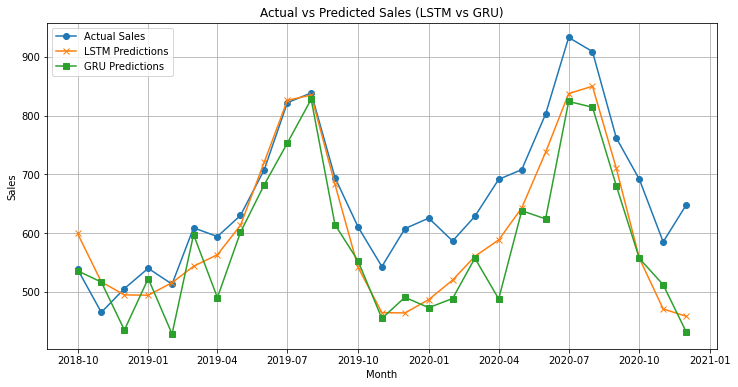

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load the dataset
df = pd.read_csv('Sales data.csv')

# Step 2: Data Preprocessing
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Display first few rows
print("Dataset:\n", df.head())

# Plot the original sales data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Data')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Step 3: Normalize the sales data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Sales'] = scaler.fit_transform(df[['Sales']])

# Step 4: Prepare data for LSTM/GRU models
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 12
data = df['Sales'].values
X, y = create_sequences(data, sequence_length)

# Split into training and testing sets (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape data to be compatible with LSTM/GRU (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 5: Build and Train LSTM Model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

lstm_model = build_lstm_model()
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_lstm = lstm_model.fit(X_train, y_train, epochs=500, batch_size=8, validation_split=0.1)

# Step 6: Evaluate LSTM Model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
lstm_mae = mean_absolute_error(y_test_inv, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_predictions))
print(f"LSTM Model - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")

# Step 7: Build and Train GRU Model
def build_gru_model():
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

gru_model = build_gru_model()
history_gru = gru_model.fit(X_train, y_train, epochs=500, batch_size=8, validation_split=0.1)

# Step 8: Evaluate GRU Model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Calculate metrics for GRU
gru_mae = mean_absolute_error(y_test_inv, gru_predictions)
gru_rmse = np.sqrt(mean_squared_error(y_test_inv, gru_predictions))
print(f"GRU Model - MAE: {gru_mae:.2f}, RMSE: {gru_rmse:.2f}")

# Step 9: Plotting Actual vs Predicted Sales
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Sales', marker='o')
plt.plot(df.index[-len(y_test):], lstm_predictions, label='LSTM Predictions', marker='x')
plt.plot(df.index[-len(y_test):], gru_predictions, label='GRU Predictions', marker='s')
plt.title('Actual vs Predicted Sales (LSTM vs GRU)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()



5/5 [==============================] - 0s 4ms/step


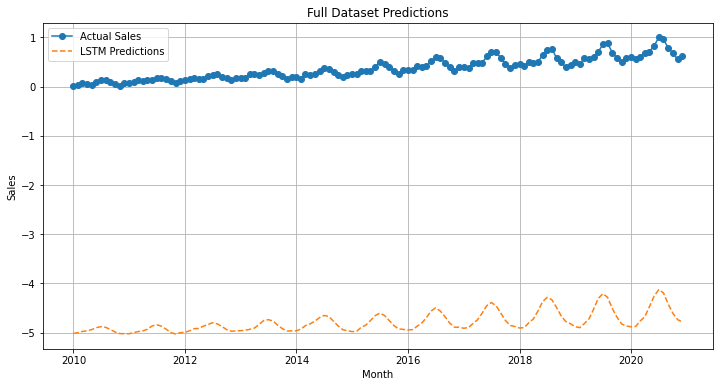

1/1 [==============================] - 0s 27ms/step


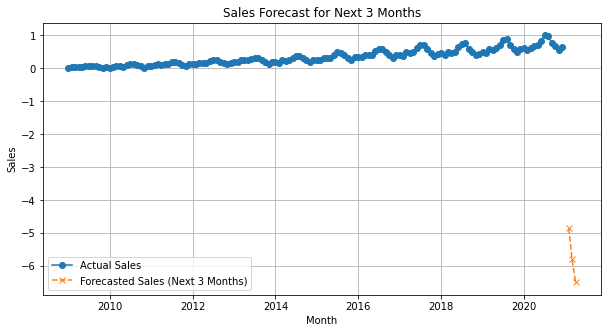


Forecasted Sales for the Next 3 Months:
        Month  Forecasted Sales
0 2021-01-31         -4.848554
1 2021-02-28         -5.787639
2 2021-03-31         -6.489903


In [14]:
# Step 10: Generate Predictions for Entire Data
# Prepare the full data sequence for predictions
full_data = df['Sales'].values.reshape(-1, 1)
full_scaled_data = scaler.transform(full_data)

# Generate sequences for the entire dataset
X_full, y_full = create_sequences(full_scaled_data, sequence_length)
X_full = X_full.reshape((X_full.shape[0], X_full.shape[1], 1))

# Predict on the entire dataset
full_predictions = lstm_model.predict(X_full)
full_predictions_inv = scaler.inverse_transform(full_predictions)

# Plotting Actual vs Full Model Predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[sequence_length:], full_data[sequence_length:], label='Actual Sales', marker='o')
plt.plot(df.index[sequence_length:], full_predictions_inv, label='LSTM Predictions', linestyle='--')
plt.title('Full Dataset Predictions')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Forecast Next 3 Months
def forecast_next_steps(model, last_sequence, n_steps):
    forecast = []
    current_sequence = last_sequence.reshape(1, sequence_length, 1)
    
    for _ in range(n_steps):
        # Predict the next value
        next_value = model.predict(current_sequence)
        
        # Append the prediction to the forecast list
        forecast.append(next_value[0, 0])
        
        # Update the sequence with the new prediction
        next_value_reshaped = next_value.reshape(1, 1, 1)  # Reshape to (1, 1, 1)
        current_sequence = np.append(current_sequence[:, 1:, :], next_value_reshaped, axis=1)
    
    return np.array(forecast)


# Get the last sequence from the original scaled data for forecasting
last_sequence = full_scaled_data[-sequence_length:]

# Forecast the next 3 months
n_months_to_forecast = 3
future_forecast = forecast_next_steps(lstm_model, last_sequence, n_months_to_forecast)

# Inverse transform the forecast to get the actual sales values
future_forecast_inv = scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Generate dates for the next 3 months
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_months_to_forecast, freq='M')

# Plotting the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], label='Actual Sales', marker='o')
plt.plot(future_dates, future_forecast_inv, label='Forecasted Sales (Next 3 Months)', marker='x', linestyle='--')
plt.title('Sales Forecast for Next 3 Months')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Display forecasted values
forecast_df = pd.DataFrame({'Month': future_dates, 'Forecasted Sales': future_forecast_inv.flatten()})
print("\nForecasted Sales for the Next 3 Months:\n", forecast_df)
